In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

## generate some fake data

let's deliberately choose something tricky- a spiral, using only x and y values as inputs:

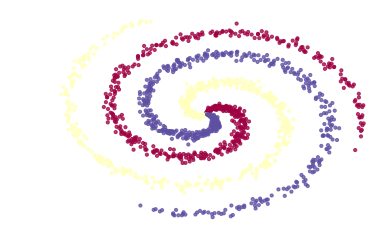

In [19]:
N = 500 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
Y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+2)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Spectral, alpha=0.75)
plt.axis("off");

In [21]:
shuffle = np.random.choice(np.arange(K*N), replace=False, size=K*N)
Y = Y[shuffle]
X = X[shuffle,:]

X_train = X[:1000,:]
X_test = X[1000:,:]
Y_train = Y[:1000]
Y_test = Y[1000:]

In [55]:
def training_curve(optimizer, epochs=1000):
    """
    """
    # define a model
    tf.reset_default_graph()
    x_ph = tf.placeholder(tf.float32, shape=[None, 2])
    y_ph = tf.placeholder(tf.int32, shape=[None,])
    y_oh = tf.one_hot(y_ph, 3)
    # let's make a tall and deep dense network
    net = tf.identity(x_ph)
    for n in [32, 32, 32, 32]:
        net = tf.layers.dense(net, n, activation=tf.nn.relu)
    logits = tf.layers.dense(net, 3)
    prediction = tf.argmax(logits, 1)
    
    loss = tf.losses.sigmoid_cross_entropy(y_oh, logits=logits)
    correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #accuracy = tf.metrics.accuracy(y_ph, prediction)[0]
    
    #train_op = optimizer(**params).minimize(loss)
    train_op = optimizer.minimize(loss)
    
    test_acc = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in tqdm(range(epochs)):
            for i in range(10):
                fd = {x_ph:X_train[100*i:100*(i+1),:], 
                      y_ph:Y_train[100*i:100*(i+1)]}
                _ = sess.run(train_op, feed_dict=fd)
            test_acc.append(sess.run(accuracy, 
                                     feed_dict={x_ph:X_test, y_ph:Y_test}))
    return test_acc

In [56]:
tests = {}

In [57]:
tests["sgd"] = training_curve(tf.train.GradientDescentOptimizer(learning_rate=1e-3))

100%|██████████| 1000/1000 [00:10<00:00, 94.79it/s]


In [58]:
tests["momentum"] = training_curve(tf.train.MomentumOptimizer(learning_rate=1e-3, momentum=0.9))

100%|██████████| 1000/1000 [00:10<00:00, 90.99it/s]


In [62]:
tests["nesterov"] = training_curve(tf.train.MomentumOptimizer(learning_rate=1e-3, momentum=0.9, 
                                                              use_nesterov=True))

100%|██████████| 1000/1000 [00:10<00:00, 93.28it/s]


In [67]:
tests["adagrad"] = training_curve(tf.train.AdagradOptimizer(1e-3, initial_accumulator_value=0.1))

100%|██████████| 1000/1000 [00:11<00:00, 89.25it/s]


In [70]:
tests["rmsprop"] = training_curve(tf.train.RMSPropOptimizer(1e-3, decay=0.9))

100%|██████████| 1000/1000 [00:11<00:00, 88.50it/s]


In [73]:
tests["adam"] = training_curve(tf.train.AdamOptimizer(1e-3, beta1=0.9, beta2=0.999))

100%|██████████| 1000/1000 [00:11<00:00, 86.54it/s]


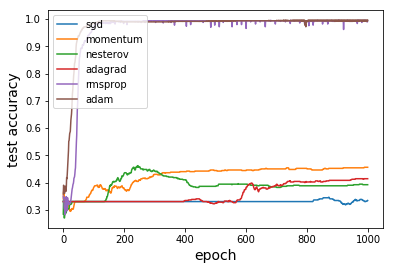

In [74]:
for k in tests:
    plt.plot(tests[k], label=k)

plt.xlabel("epoch", fontsize=14)
plt.ylabel("test accuracy", fontsize=14)
#plt.grid("on")
plt.legend(loc="upper left");